# Swap Network

Functionality for moving data between registers (swapping).

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `CSwap`
Swap two registers controlled on a control bit.

Implements a multi-target controlled swap unitary $CSWAP_n = |0><0| I + |1><1| SWAP_n$.

This decomposes into a qubitwise SWAP on the two target registers, and takes $14n$ T-gates.

#### Parameters
 - `bitsize`: The bitsize of each of the two registers being swapped. 

#### Registers
 - `ctrl`: the control bit
 - `x`: the first register
 - `y`: the second register


In [2]:
from qualtran.bloqs.basic_gates import CSwap

### Example Instances

In [3]:
# A symbolic version. The bitsize is the symbol 'n'.
from sympy import sympify

cswap_symb = CSwap(bitsize=sympify('n'))

In [4]:
# A small version on four bits.
cswap_small = CSwap(bitsize=4)

In [5]:
# A large version that swaps 64-bit registers.
cswap_large = CSwap(bitsize=64)

#### Graphical Signature

In [6]:
from qualtran.drawing import show_bloqs
show_bloqs([cswap_symb, cswap_small, cswap_large],
           ['`cswap_symb`', '`cswap_small`', '`cswap_large`'])

### Call Graph

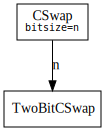

#### Counts totals:
 - `TwoBitCSwap()`: $\displaystyle n$

In [7]:
from qualtran.resource_counting.generalizers import ignore_split_join
cswap_symb_g, cswap_symb_sigma = cswap_symb.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(cswap_symb_g)
show_counts_sigma(cswap_symb_sigma)

## `CSwapApprox`
Approximately implements a multi-target controlled swap unitary using only $4n$ T-gates.

Implements $\mathrm{CSWAP}_n = |0 \rangle\langle 0| I + |1 \rangle\langle 1| \mathrm{SWAP}_n$
such that the output state is correct up to a global phase factor of +1 / -1.

This is useful when the incorrect phase can be absorbed in a garbage state of an algorithm
and thus ignored. See the reference for more details.

#### Parameters
 - `bitsize`: The bitsize of the two registers being swapped. 

#### Registers
 - `ctrl`: the control bit
 - `x`: the first register
 - `y`: the second register 

#### References
 - [Trading T-gates for dirty qubits in state preparation and unitary synthesis](https://arxiv.org/abs/1812.00954). Low et. al. 2018. See Appendix B.2.c.


In [8]:
from qualtran.bloqs.swap_network import CSwapApprox

### Example Instances

In [9]:
# A symbolic version. The bitsize is the symbol 'n'.
from sympy import sympify

approx_cswap_symb = CSwapApprox(bitsize=sympify('n'))

In [10]:
# A small version on four bits.
approx_cswap_small = CSwapApprox(bitsize=4)

In [11]:
# A large version that swaps 64-bit registers.
approx_cswap_large = CSwapApprox(bitsize=64)

#### Graphical Signature

In [12]:
from qualtran.drawing import show_bloqs
show_bloqs([approx_cswap_symb, approx_cswap_small, approx_cswap_large],
           ['`approx_cswap_symb`', '`approx_cswap_small`', '`approx_cswap_large`'])

### Call Graph

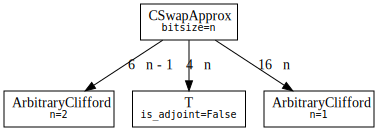

#### Counts totals:
 - `ArbitraryClifford(n=1)`: $\displaystyle 16 n$
 - `ArbitraryClifford(n=2)`: $\displaystyle 6 n - 1$
 - `TGate()`: $\displaystyle 4 n$

In [13]:
from qualtran.resource_counting.generalizers import ignore_split_join
approx_cswap_symb_g, approx_cswap_symb_sigma = approx_cswap_symb.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(approx_cswap_symb_g)
show_counts_sigma(approx_cswap_symb_sigma)

## `SwapWithZero`
Swaps |Psi_0> with |Psi_x> if selection register stores index `x`.

Implements the unitary U |x> |Psi_0> |Psi_1> ... |Psi_{n-1}> --> |x> |Psi_x> |Rest of Psi>.
Note that the state of `|Rest of Psi>` is allowed to be anything and should not be depended
upon.

#### References
 - [Trading T-gates for dirty qubits in state preparation and unitary synthesis](https://arxiv.org/abs/1812.00954). Low, Kliuchnikov, Schaeffer. 2018.


In [14]:
from qualtran.bloqs.swap_network import SwapWithZero

### Example Instances

In [15]:
swz = SwapWithZero(selection_bitsize=8, target_bitsize=32, n_target_registers=4)

In [16]:
# A small version on four bits.
swz_small = SwapWithZero(selection_bitsize=3, target_bitsize=2, n_target_registers=2)

#### Graphical Signature

In [17]:
from qualtran.drawing import show_bloqs
show_bloqs([swz, swz_small],
           ['`swz`', '`swz_small`'])

### Call Graph

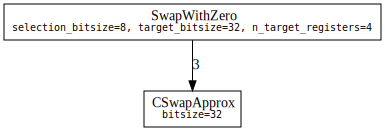

#### Counts totals:
 - `CSwapApprox(bitsize=32)`: 3

In [18]:
from qualtran.resource_counting.generalizers import ignore_split_join
swz_g, swz_sigma = swz.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(swz_g)
show_counts_sigma(swz_sigma)

## `MultiplexedCSwap`
Swaps the $l$-th register into an ancilla using unary iteration.

Applies the unitary which performs
$$
    U |l\rangle|\psi_0\rangle\cdots|\psi_l\rangle\cdots|\psi_n\rangle|\mathrm{junk}\rangle
    \rightarrow
    |l\rangle|\psi_0\rangle\cdots|\mathrm{junk}\rangle\cdots|\psi_n\rangle|\psi_l\rangle
$$
through a combination of unary iteration and CSwaps.

The toffoli cost should be $L n_b + L - 2 + n_c$, where $L$ is the
iteration length, $n_b$ is the bitsize of
the registers to swap, and $n_c$ is the number of controls.

#### Parameters
 - `selection_regs`: Indexing `select` signature of type Tuple[[`Register`](/reference/qualtran/Register.md), ...]. It also contains information about the iteration length of each selection register.
 - `target_bitsize`: The size of the registers we want to swap.
 - `control_regs`: Control registers for constructing a controlled version of the gate. 

#### Registers
 - `control_registers`: Control registers
 - `selection_regs`: Indexing `select` signature of type Tuple[[`Register`](/reference/qualtran/Register.md), ...]. It also contains information about the iteration length of each selection register.
 - `target_registers`: Target registers to swap. We swap FROM registers labelled x`i`, where i is an integer and TO a single register called y 

#### References
 - [Fault-Tolerant Quantum Simulations of Chemistry in First Quantization](https://arxiv.org/abs/2105.12767). page 20 paragraph 2.


In [19]:
from qualtran.bloqs.swap_network import MultiplexedCSwap

### Example Instances

In [20]:
from qualtran import BoundedQUInt

selection_bitsize = 3
iteration_length = 5
target_bitsize = 2
multiplexed_cswap = MultiplexedCSwap(
    Register('selection', BoundedQUInt(selection_bitsize, iteration_length)),
    target_bitsize=target_bitsize,
)


#### Graphical Signature

In [21]:
from qualtran.drawing import show_bloqs
show_bloqs([multiplexed_cswap],
           ['`multiplexed_cswap`'])

### Call Graph

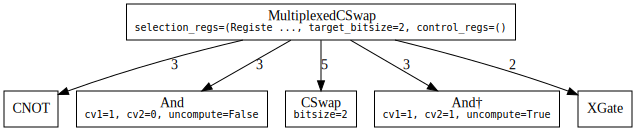

#### Counts totals:
 - `And(cv1=1, cv2=0, uncompute=False)`: 3
 - `And(cv1=1, cv2=1, uncompute=True)`: 3
 - `CNOT()`: 3
 - `CSwap(bitsize=2)`: 5
 - `XGate()`: 2

In [22]:
from qualtran.resource_counting.generalizers import ignore_split_join
multiplexed_cswap_g, multiplexed_cswap_sigma = multiplexed_cswap.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(multiplexed_cswap_g)
show_counts_sigma(multiplexed_cswap_sigma)